# The Credit Card Fraud Dataset - Synthesizing the Minority Class

In this notebook a practical exercise is presented to showcase the usage of the YData Synthetic library along with
GANs to synthesize tabular data.
For the purpose of this exercise, dataset of credit card fraud from Kaggle is used, that can be found here:
https://www.kaggle.com/mlg-ulb/creditcardfraud

In [11]:
# Note: You can select between running the Notebook on "CPU" or "GPU"
# Click "Runtime > Change Runtime time" and set "GPU"

In [12]:
# Install ydata-synthetic lib
# ! pip install ydata-synthetic

In [13]:
import importlib
import os
import sys  

import pandas as pd
import numpy as np
import sklearn.cluster as cluster
import matplotlib.pyplot as plt

from ydata_synthetic.synthesizers.regular import VanilllaGAN
from ydata_synthetic.preprocessing.regular.credit_fraud import *

model = VanilllaGAN

In [14]:
# Read the original data and have it preprocessed
data = pd.read_csv('./data/creditcard.csv', index_col=[0])

In [15]:
# Extract list of columns
data_cols = list(data.columns[ data.columns != 'Class' ])

print('Dataset columns: {}'.format(data_cols))
sorted_cols = ['V14', 'V4', 'V10', 'V17', 'V12', 'V26', 'Amount', 'V21', 'V8', 'V11', 'V7', 'V28', 'V19', 'V3', 'V22', 'V6', 'V20', 'V27', 'V16', 'V13', 'V25', 'V24', 'V18', 'V2', 'V1', 'V5', 'V15', 'V9', 'V23', 'Class']
processed_data = data[ sorted_cols ].copy()

Dataset columns: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']


In [16]:
# Before training the GAN do not forget to apply the required data transformations
# To ease here we've applied a PowerTransformation - make data distribution more Gaussian-like.
data = transformations(data)

# For the purpose of this example we will only synthesize the minority class
# train_data contains 492 rows which had 'Class' value as 1 (which were very few)
train_data = data.loc[ data['Class']==1 ].copy()

print("Dataset info: Number of records - {} Number of variables - {}".format(train_data.shape[0], train_data.shape[1]))

# We define a K-means clustering method using sklearn, and declare that
# we want 2 clusters. We then apply this algorithm (fit_predict) to our train_data
# We essentially get an array of 492 rows ('labels') having values either 0 or 1 for the 2 clustered classes.
algorithm = cluster.KMeans
args, kwds = (), {'n_clusters':2, 'random_state':0}
labels = algorithm(*args, **kwds).fit_predict(train_data[ data_cols ])

# Get the count of both classes
print( pd.DataFrame( [ [np.sum(labels==i)] for i in np.unique(labels) ], columns=['count'], index=np.unique(labels) ) )

# Assign the k-means clustered classes' labels to the a seperate copy of train data 'fraud_w_classes'
fraud_w_classes = train_data.copy()
fraud_w_classes['Class'] = labels

Dataset info: Number of records - 492 Number of variables - 30
   count
0    384
1    108


# GAN training

Below you can try to train your own generators using the available GANs architectures. You can train it either with labels (created using KMeans) or with no labels at all. 

Remember that for this exercise in particular we've decided to synthesize only the minority class from the Credit Fraud dataset.

In [17]:
# Define the GAN and training parameters
noise_dim = 32
dim = 128
batch_size = 128

log_step = 100
epochs = 200+1
learning_rate = 5e-4
beta_1 = 0.5
beta_2 = 0.9
models_dir = './cache'

train_sample = fraud_w_classes.copy().reset_index(drop=True)
print("train_sample.columns:")
print(train_sample.columns)

# There's only 1 class, so essentially rename the 'Class' to 'Class_1',
# which tells weather a sample data is of class 1 or not.
train_sample = pd.get_dummies(train_sample, columns=['Class'], prefix='Class', drop_first=True)

# 'Class_1' label
label_cols = [ i for i in train_sample.columns if 'Class' in i ]

# All columns except 'Class_1'
data_cols = [ i for i in train_sample.columns if i not in label_cols ]

# Scale down the data, and rename it to 'train_no_label'
train_sample[ data_cols ] = train_sample[ data_cols ] / 10 # scale to random noise size, one less thing to learn
train_no_label = train_sample[ data_cols ]

gan_args = [batch_size, learning_rate, beta_1, beta_2, noise_dim, train_sample.shape[1], dim]
train_args = ['', epochs, log_step]

train_sample.columns:
Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class'],
      dtype='object')

train_sample.columns after pd.get_dummies:
Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class_1'],
      dtype='object')

label_cols:
['Class_1']

data_cols:
['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']


In [19]:
# Training the GAN model chosen: Vanilla GAN, CGAN, DCGAN, etc.
synthesizer = model(gan_args)
synthesizer.train(train_sample, train_args)

0 [D loss: 0.710603, acc.: 13.67%] [G loss: 0.693972]
generated_data
1 [D loss: 0.667089, acc.: 51.56%] [G loss: 0.694437]
2 [D loss: 0.642068, acc.: 50.78%] [G loss: 0.687124]
3 [D loss: 0.637339, acc.: 50.00%] [G loss: 0.668181]
4 [D loss: 0.651023, acc.: 50.00%] [G loss: 0.643846]
5 [D loss: 0.664150, acc.: 50.00%] [G loss: 0.622516]
6 [D loss: 0.703400, acc.: 50.00%] [G loss: 0.618456]
7 [D loss: 0.735280, acc.: 48.83%] [G loss: 0.600748]
8 [D loss: 0.780682, acc.: 48.44%] [G loss: 0.600011]
9 [D loss: 0.811588, acc.: 46.48%] [G loss: 0.623603]
10 [D loss: 0.804441, acc.: 39.84%] [G loss: 0.671915]
11 [D loss: 0.788958, acc.: 23.83%] [G loss: 0.776565]
12 [D loss: 0.751743, acc.: 27.73%] [G loss: 0.884803]
13 [D loss: 0.711271, acc.: 53.12%] [G loss: 0.980368]
14 [D loss: 0.686299, acc.: 57.81%] [G loss: 1.075067]
15 [D loss: 0.652931, acc.: 57.03%] [G loss: 1.148679]
16 [D loss: 0.625157, acc.: 57.81%] [G loss: 1.173239]
17 [D loss: 0.607870, acc.: 58.98%] [G loss: 1.181916]
18 [D

In [20]:
# Generator description
synthesizer.generator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(128, 32)]               0         
_________________________________________________________________
dense (Dense)                (128, 128)                4224      
_________________________________________________________________
dense_1 (Dense)              (128, 256)                33024     
_________________________________________________________________
dense_2 (Dense)              (128, 512)                131584    
_________________________________________________________________
dense_3 (Dense)              (128, 30)                 15390     
Total params: 184,222
Trainable params: 184,222
Non-trainable params: 0
_________________________________________________________________


In [21]:
# Discriminator description
synthesizer.discriminator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(128, 30)]               0         
_________________________________________________________________
dense_4 (Dense)              (128, 512)                15872     
_________________________________________________________________
dropout (Dropout)            (128, 512)                0         
_________________________________________________________________
dense_5 (Dense)              (128, 256)                131328    
_________________________________________________________________
dropout_1 (Dropout)          (128, 256)                0         
_________________________________________________________________
dense_6 (Dense)              (128, 128)                32896     
_________________________________________________________________
dense_7 (Dense)              (128, 1)                  129 

In [22]:
# You can easily save the trained generator and loaded it afterwards
if not os.path.exists("./saved/gan"):
    os.makedirs("./saved/gan")
synthesizer.save(path="./saved/gan/generator_fraud.pkl")

In [23]:
models = {'GAN': ['GAN', False, synthesizer.generator]}

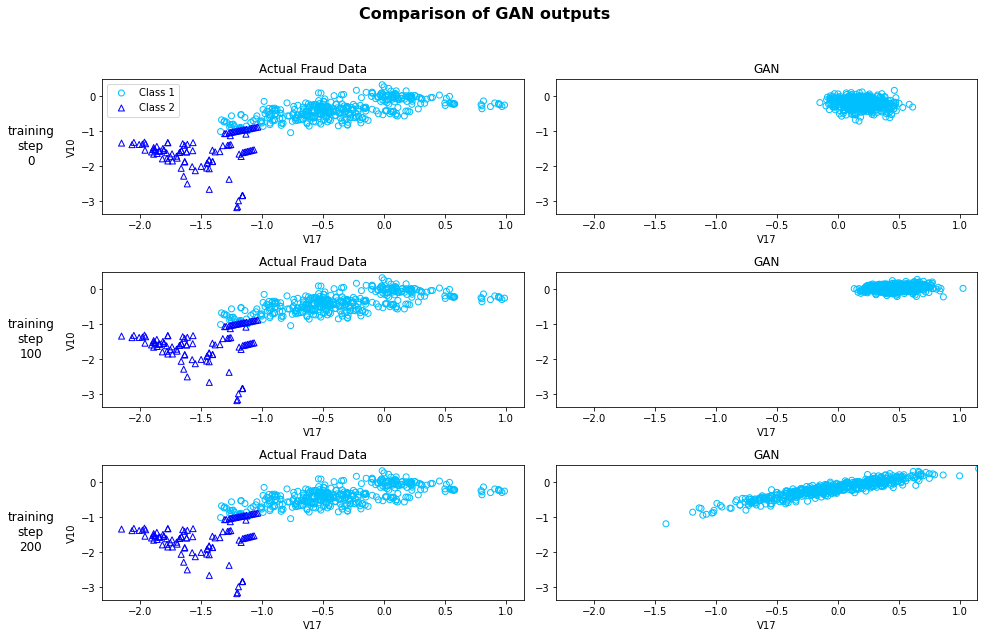

In [38]:
# Setup parameters visualization parameters
seed = 17
test_size = 492 # number of fraud cases
noise_dim = 32

np.random.seed(seed)
z = np.random.normal(size=(test_size, noise_dim))
real = synthesizer.get_data_batch(train=train_sample, batch_size=test_size, seed=seed)
real_samples = pd.DataFrame(real, columns=data_cols+label_cols)
labels = fraud_w_classes['Class']

model_names = ['GAN']
colors = ['deepskyblue','blue']
markers = ['o','^']
class_labels = ['Class 1','Class 2']

col1, col2 = 'V17', 'V10'

base_dir = 'cache/'

# Actual fraud data visualization
model_steps = [ 0, 100, 200]
rows = len(model_steps)
columns = 1 + len(models)

axarr = [[]]*len(model_steps)

fig = plt.figure(figsize=(14,rows*3))

# Go through each of the 3 model_step values -> 0, 100, 200
for model_step_ix, model_step in enumerate(model_steps):        
    axarr[model_step_ix] = plt.subplot(rows, columns, model_step_ix*columns + 1)

    # Plot 'Class 1' and 'Class 2' samples taken from the original data, in a random shuffled fashion
    for group, color, marker, label in zip(real_samples.groupby('Class_1'), colors, markers, class_labels ):
        plt.scatter( group[1][[col1]], group[1][[col2]], 
                         label=label, marker=marker, edgecolors=color, facecolors='none' )
    
    plt.title('Actual Fraud Data')
    plt.ylabel(col2) # Only add y label to left plot
    plt.xlabel(col1)
    xlims, ylims = axarr[model_step_ix].get_xlim(), axarr[model_step_ix].get_ylim()
    
    if model_step_ix == 0: 
        legend = plt.legend()
        legend.get_frame().set_facecolor('white')

    # Go through all the GAN models listed in 'model_names' and defined in 'models'
    for i, model_name in enumerate( model_names[:] ):

        [model_name, with_class, generator_model] = models[model_name]

        generator_model.load_weights( base_dir + '_generator_model_weights_step_'+str(model_step)+'.h5')

        ax = plt.subplot(rows, columns, model_step_ix*columns + 1 + (i+1) )

        if with_class:
            g_z = generator_model.predict([z, labels])
            gen_samples = pd.DataFrame(g_z, columns=data_cols+label_cols)
            for group, color, marker, label in zip( gen_samples.groupby('Class_1'), colors, markers, class_labels ):
                plt.scatter( group[1][[col1]], group[1][[col2]], 
                                 label=label, marker=marker, edgecolors=color, facecolors='none' )
        else:
            g_z = generator_model.predict(z)
            gen_samples = pd.DataFrame(g_z, columns=data_cols+['label'])
            gen_samples.to_csv('./data/Generated_sample.csv')
            plt.scatter( gen_samples[[col1]], gen_samples[[col2]],
                             label=class_labels[0], marker=markers[0], edgecolors=colors[0], facecolors='none' )
        plt.title(model_name)   
        plt.xlabel(col1)
        ax.set_xlim(xlims), ax.set_ylim(ylims)

plt.suptitle('Comparison of GAN outputs', size=16, fontweight='bold')
plt.tight_layout(rect=[0.075,0,1,0.95])

# Adding text labels for training steps
vpositions = np.array([ i._position.bounds[1] for i in axarr ])
vpositions += ((vpositions[0] - vpositions[1]) * 0.35 )
for model_step_ix, model_step in enumerate( model_steps ):
    fig.text( 0.05, vpositions[model_step_ix], 'training\nstep\n'+str(model_step), ha='center', va='center', size=12)

if not os.path.exists("./img"):
    os.makedirs("./img")
plt.savefig('img/Comparison_of_GAN_outputs.png', dpi=100)